<a href="https://colab.research.google.com/github/bahrad/Covid/blob/main/Covid_Pred_Taxonomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import csv

import pandas as pd
import pickle

In [ ]:
!python --version

Python 3.7.12


In [ ]:
from google.colab import drive, files
# drive.mount('/content/drive')

FILELOC = "/content/drive/My Drive/COVID_Python/"

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    tpu_env=True
except ValueError:
    print('Not connected to a TPU runtime.')
    tpu_env=False

Running on TPU  ['10.27.255.98:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.27.255.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.255.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
def reset_model(regress, singleclass, multiclass, output_multiheadatt, use_att, nclasses=4,
                output_two=False):

    if output_multiheadatt:
        model_fn = AttMod_2
    elif output_two:
        model_fn = AttMod_3
    else:
        model_fn = AttModel

    model = model_fn(L=ismlen,
                     vocab_size=len(aa_list)+1,
                     embdim = ENCDIM,
                     numheads = NHEADS,
                     ffdim = FFDIM,
                     num_dense = NDENSE,
                     mask_zero=True,
                     dropout_rate = DROPRATE,
                     trans_drop = TRANSDROPRATE,
                     Nt = NT,
                     W = 1, Nc = NC, Nl = NL,
                     regress=regress, singleclass=singleclass,
                     multiclass=multiclass, use_att=use_att,
                     nclasses=nclasses,
                     )
    
    optimizer = keras.optimizers.Adam(learning_rate=LEARN_RATE)
    if regress:
        loss = keras.losses.MeanSquaredError()
        metrics = [keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanSquaredLogarithmicError(name='msle'),
            keras.losses.MeanAbsoluteError(name='mae')
            ]
    if singleclass:
        loss = keras.losses.BinaryCrossentropy()
        metrics = [keras.metrics.BinaryAccuracy(name='acc'),
                   keras.metrics.AUC(name='auc')]
    if multiclass:    
        loss = keras.losses.SparseCategoricalCrossentropy()
        metrics = [keras.metrics.SparseCategoricalAccuracy(name='acc')]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics,)
                #   steps_per_execution = STEPS_PER_EXECUTION,)

    if output_two:
        losses = {'outfirst':'mean_squared_error',
                  'outpeak':'mean_squared_error'}
        lossweights = {'outfirst':1.0, 'outpeak':1.0}
        metrics = [keras.metrics.MeanSquaredError(name='mse'),
                   keras.metrics.MeanSquaredLogarithmicError(name='msle'),
                   keras.losses.MeanAbsoluteError(name='mae')]
        model.compile(loss=losses, loss_weights=lossweights, optimizer=optimizer,metrics=metrics)

    return model

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, mask_zero=False):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                mask_zero=mask_zero)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                              mask_zero=mask_zero)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def linear01(x):
    return tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

In [ ]:
def AttMod_2(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False,
             regress=True, singleclass=False, multiclass=False, use_att=True,
             nclasses=4):

    inpTensor = keras.Input(shape=(L,))
    x = inpTensor

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    y, attout = keras.layers.MultiHeadAttention(num_heads=numheads, key_dim=embdim,
                                                )(x, x, return_attention_scores=True)
    y = keras.layers.Dropout(trans_drop)(y)
    z = keras.layers.LayerNormalization(epsilon=1e-6)(x + y)
    z1 = keras.Sequential( [keras.layers.Dense(ffdim, activation="relu"), keras.layers.Dense(embdim),])
    z1 = keras.layers.Dropout(trans_drop)(z)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(z + z1)

    if use_att:
        # Attention layer
        h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
        attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
        attention = keras.layers.Flatten()(attention)  
        attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
        attention = keras.layers.RepeatVector(Nc)(attention)
        attention = keras.layers.Permute([2, 1])(attention)
        representation = keras.layers.multiply([h, attention])
        representation = tf.math.reduce_sum(representation, axis = 1)
        x = representation
    else:
        x = keras.layers.GlobalAveragePooling1D()(x)

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu')(x)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    if regress:
        finalOut = keras.layers.Dense(1, activation=linear01)(x)
    if singleclass:
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if multiclass:
        finalOut = keras.layers.Dense(nclasses, activation='softmax')(x)

    # define the model's start and end points    
    model = keras.Model(inpTensor,finalOut)

    return model

In [ ]:
def AttModel(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False,
             regress=True, singleclass=False, multiclass=False, use_att=True,
             nclasses=4):

    inpTensor = keras.Input(shape=(L,))
    x = inpTensor

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    if use_att:
        # Attention layer
        h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
        attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
        attention = keras.layers.Flatten()(attention)  
        attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
        attention = keras.layers.RepeatVector(Nc)(attention)
        attention = keras.layers.Permute([2, 1])(attention)
        representation = keras.layers.multiply([h, attention])
        representation = tf.math.reduce_sum(representation, axis = 1)
        x = representation
    else:
        x = keras.layers.GlobalAveragePooling1D()(x)

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu')(x)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    if regress:
        # finalOut = keras.layers.Dense(1, activation=linear01)(x)
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if singleclass:
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if multiclass:
        finalOut = keras.layers.Dense(nclasses, activation='softmax')(x)

    # define the model's start and end points    
    model = keras.Model(inpTensor,finalOut)

    return model

In [ ]:
def AttMod_3(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False,
             regress=True, singleclass=False, multiclass=False, use_att=True,
             nclasses=4):

    inpTensor = keras.Input(shape=(L,))
    x = inpTensor

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    if use_att:
        # Attention layer
        h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
        attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
        attention = keras.layers.Flatten()(attention)  
        attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
        attention = keras.layers.RepeatVector(Nc)(attention)
        attention = keras.layers.Permute([2, 1])(attention)
        representation = keras.layers.multiply([h, attention])
        representation = tf.math.reduce_sum(representation, axis = 1)
        x = representation
    else:
        x = keras.layers.GlobalAveragePooling1D()(x)

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu')(x)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    if regress:
        # finalOut = keras.layers.Dense(1, activation=linear01)(x)
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if singleclass:
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if multiclass:
        finalOut = keras.layers.Dense(nclasses, activation='softmax')(x)

    out1 = keras.layers.Dense(1, activation='sigmoid', name='outfirst')(x)
    out2 = keras.layers.Dense(1, activation='sigmoid', name='outpeak')(x)
    # define the model's start and end points    
    model = keras.Model(inpTensor,[out1,out2])

    return model

In [ ]:
# These parameters are currently hard-coded
ENCDIM = 1500
NC = 300
NL = 1
NT = 1
NHEADS = 8
FFDIM = 64
NDENSE = 64
TRANSDROPRATE = 0.1
DROPRATE = 0.0

LEARN_RATE = 0.0001

BATCH_SIZE = 48

STEPS_PER_EXECUTION = 50

#Dataset Preprocessing

In [ ]:
data = pd.read_csv(FILELOC + "species_dataset_20211127.csv")

In [ ]:
dataset = data[(data.Length>1000) & (data.Species.str.contains('coronavirus'))].copy()

In [ ]:
dataset['Label'] = dataset.Host.apply(lambda x: 1 if x=='Homo sapiens' else 0)

In [ ]:
def f(x):
    if x=='Alphacoronavirus':
        return 0
    if x=='Betacoronavirus':
        return 1
    if x=='Gammacoronavirus':
        return 2

dataset['genuslabel'] = dataset.Genus.apply(f)

In [ ]:
# dataset.to_csv(FILELOC + 'species_dataset_2021110.csv')
# np.savetxt(FILELOC + 'species_dataset_2021110_genuslabels.csv', dataset.genuslabel.values)

In [ ]:
dataset['date'] = dataset['Release_Date'].apply(lambda x:dateparse(x))
dataset['date'] = dataset['date'].dt.date

In [ ]:
len(dataset[dataset.Collection_Date.isna()])

1138

In [ ]:
# dataset.to_csv(FILELOC + 'species_dataset_2021111.csv')

In [ ]:
# np.savetxt(FILELOC + 'species_dataset_2021111_genuslabels.csv', dataset.genuslabel.values)
# with open(FILELOC + 'species_dataset_2021111_data.csv', 'w') as f:
#     csv.writer(f).writerows(dataset.Seq.values)
# np.savetxt(FILELOC + 'species_dataset_2021111_labels.csv', dataset.Label.values)

In [ ]:
SEQLEN = 1500

def f(x):
    if len(x) < SEQLEN:
        return x + '*'*(SEQLEN-len(x))
    elif len(x) > SEQLEN:
        return x[:SEQLEN]
    else:
        return x

dataset['PadSeq'] = dataset['Seq'].apply(f)

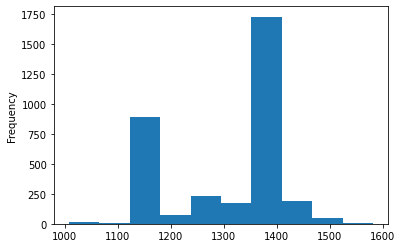

In [ ]:
dataset.Seq.apply(len).plot.hist()

The following is how to do a label, where 1 is Human and 0 is Non-Human

In [ ]:
dataset['hostlabel'] = dataset.Host.apply(lambda x: 1 if x=='Homo sapiens' else 0)

The following is how to do a label for coronavirus genus, where 0, 1, 2, and 3 are different coronavirus genuses

In [ ]:
def f(x):
    if x=='Alphacoronavirus':
        return 0
    if x=='Betacoronavirus':
        return 1
    if x=='Gammacoronavirus':
        return 2
    if x=='Deltacoronavirus':
        return 3

dataset['genuslabel'] = dataset.Genus.apply(f)

In [ ]:
dataset['date'] = dataset['Release_Date'].apply(lambda x:dateparse(x))
dataset['date'] = dataset['date'].dt.date

#Taxonomic Prediction

In [ ]:
ismlen = 1500

def tokenize_sequences(data_dataframe, SeqCol='ISM', seqlen=1273):
    def f(x):
        if len(x) < seqlen:
            return x + '*'*(seqlen-len(x))
        elif len(x) > seqlen:
            return x[:seqlen]
        else:
            return x
    data = np.vstack(data_dataframe[SeqCol].apply(f).apply(lambda x: np.array(list(x))))
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
            'G', 'H', 'I', 'L', 'K', 'M', 'F',
            'P', 'S', 'T', 'W', 'Y', 'V', '-',
            ]
    aa_tokenizer = {aa_list[k]:k+1 for k in range(len(aa_list))}
    aa_tokenizer['*'] = 0
    aa_tokenizer['X'] = 0
    # optionally handle B, J, Z ambiguities
    # Asx	B	Aspartic acid or Asparagine (D or N)
    # Glx	Z	Glutamic acid or Glutamine (E or Q)
    # Xaa	X	Any amino acid
    # Xle	J	Leucine or Isoleucine (L or I)
    aa_tokenizer['B'] = 0
    aa_tokenizer['Z'] = 0
    aa_tokenizer['J'] = 0

    return np.vectorize(aa_tokenizer.get)(data)

aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
        'G', 'H', 'I', 'L', 'K', 'M', 'F',
        'P', 'S', 'T', 'W', 'Y', 'V', '-',
        ]

In [ ]:
datadf['seqlen'] = datadf.Seq.apply(len)

In [ ]:
seqtok = tokenize_sequences(dataset, 'Seq', 1500)
y = dataset.genuslabel

In [ ]:
seqtok = tokenize_sequences(datadf[datadf.seqlen>1000], 'Seq', 1500)
y = datadf[datadf.seqlen>1000].genuslabel

Manually create train-test split indices

In [ ]:
trainindex = np.random.choice(range(len(seqtok)), size = int(0.9*len(seqtok)), replace=False)
testindex = [k for k in range(len(seqtok)) if k not in trainindex]

# save train index for future use:
np.savetxt(FILELOC + 'species_trainindex_2021121.csv', trainindex, fmt='%i', delimiter=',')
trainindex = np.loadtxt(FILELOC + 'species_reduced_trainindex_2021121.csv', dtype=int, delimiter=',')

testindex = [k for k in range(len(seqtok)) if k not in trainindex]
xtraintok = seqtok[trainindex]; ytrain = y[trainindex]
xtesttok = seqtok[testindex]; ytest = y[testindex]

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                       classes=np.unique(y), y=y))
sample_weights = np.array([class_weights[int(yi)] for yi in y])
print(class_weights)

[1.1203703703703705, 0.6364894795127354, 0.8668929110105581, 2.6125]


In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 48
VAL_SPLIT = 0.2

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 1,
    patience = 10, #5,
    mode = 'auto',
    min_delta = 0,
    restore_best_weights = True
    )

tf.keras.backend.clear_session()
if tpu_env:
    with tpu_strategy.scope():
        model = reset_model(regress=False, singleclass=False, multiclass=True,
                            output_multiheadatt=False, use_att=True, nclasses=4)
else:
    model = reset_model(regress=False, singleclass=False, multiclass=True,
                        output_multiheadatt=False, use_att=True, nclasses=4)
history = model.fit(xtraintok, ytrain,
                    sample_weight = sample_weights,
                    batch_size = BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    verbose = 1,
                    # validation_split = VAL_SPLIT,
                    # callbacks = [early_stopping],
                    )

# to save weights of the model
model.save_weights(f"{FILELOC}taxonomy_weights.h5", save_format='h5', overwrite=True)

##Load Pretrained Model

In [ ]:
ismlen = 1500

def tokenize_sequences(data_dataframe, SeqCol='ISM', seqlen=1273):
    def f(x):
        if len(x) < seqlen:
            return x + '*'*(seqlen-len(x))
        elif len(x) > seqlen:
            return x[:seqlen]
        else:
            return x
    data = np.vstack(data_dataframe[SeqCol].apply(f).apply(lambda x: np.array(list(x))))
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
            'G', 'H', 'I', 'L', 'K', 'M', 'F',
            'P', 'S', 'T', 'W', 'Y', 'V', '-',
            ]
    aa_tokenizer = {aa_list[k]:k+1 for k in range(len(aa_list))}
    aa_tokenizer['*'] = 0
    aa_tokenizer['X'] = 0
    # optionally handle B, J, Z ambiguities
    # Asx	B	Aspartic acid or Asparagine (D or N)
    # Glx	Z	Glutamic acid or Glutamine (E or Q)
    # Xaa	X	Any amino acid
    # Xle	J	Leucine or Isoleucine (L or I)
    aa_tokenizer['B'] = 0
    aa_tokenizer['Z'] = 0
    aa_tokenizer['J'] = 0

    return np.vectorize(aa_tokenizer.get)(data)

aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
        'G', 'H', 'I', 'L', 'K', 'M', 'F',
        'P', 'S', 'T', 'W', 'Y', 'V', '-',
        ]

Analysis of error only for multiple runs of Transformer model

In [ ]:
# # align = pd.read_csv(FILELOC+'align1001_all.csv')
# raw = pd.read_csv(FILELOC + 'results1001_Spike.csv')
# raw.drop_duplicates('Seq', inplace=True)

# raw['seqlen'] = raw.Spike.apply(len)
# raw['X'] = raw.Spike.apply(lambda x: x.count('X'))
# print(len(raw), len(raw[raw.X > 0]), len(raw[raw.seqlen.between(1271,1273)]), len(raw[raw.seqlen<1000]))

# raw_sample = raw.sample(100000)
# raw_short = raw[raw.seqlen<1000]
# raw_short.drop_duplicates('Spike', inplace=True)
# raw_noise.drop_duplicates('Spike', inplace=True)

# with open(f'{FILELOC}coronovirus_spike_taxonomy_sequence_samples.pkl', 'wb') as f:
#     pickle.dump([raw_sample, align_sample, raw_short, align_short, align_noise], f)

with open(f'{FILELOC}coronovirus_spike_taxonomy_sequence_samples.pkl', 'rb') as f:
    rawsample, rawshort, rawnoise = pickle.load(f)

In [ ]:
align = pd.read_csv(FILELOC+'align1001_all.csv')
df = align['MaskedSeq'].value_counts().to_frame().rename(columns={"MaskedSeq":"Count"})
# mdf = pd.read_csv(FILELOC + 'metadata.tsv', '\t')
# mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')
with open(FILELOC + 'aligned_sequence_lineages_1001.pkl', 'rb') as f:
    mdf,_ = pickle.load(f)
df = df.join(mdf).reset_index(drop=False).rename(columns={'index':'MaskedSeq'})

In [ ]:
lin = ['B.1.526', 'B.1.427', 'B.1.617.2', 'AY.4', 'B.1.351', 'B.1', 'A', 'P.1', 'B.1.1.7', 'C.37']
indices = []
for l in lin:
    indices.append(df[(df.Lineage==l) & (df.Count==df[df.Lineage==l]['Count'].max())].index[0])
tdf = df.loc[indices].copy()
tdf.reset_index(drop=True, inplace=True)

In [ ]:
REFSPIKE = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'

In [ ]:
tdf.loc[len(tdf.index)] = [REFSPIKE, 1, 'Wu-Ref']

In [ ]:
omicron = pd.read_csv(FILELOC + 'omicron_spike_20211209.csv')
omiseq = omicron['Align'].value_counts().index[0]
tdf.loc[len(tdf.index)] = [omiseq, omicron['Align'].value_counts().values[0], 'Omicron']

In [ ]:
# run = 8
run = 1

tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    # model.load_weights(f"{FILELOC}taxonomy_weights_20211213_{run}.h5")
    # model.load_weights(f"{FILELOC}taxonomy_weights_20211221_{run}.h5")
    model.load_weights(f"{FILELOC}taxonomy_weights_20220112_seq1000_{run}.h5")
    model.compile()

In [ ]:
tok = tokenize_sequences(tdf,'MaskedSeq',1500)

with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    pred = model.predict(tok)
    emb = get_embedding_model.predict(tok)
    att = get_attention_model.predict(tok)
    tdf['pred'] = [p for p in pred]
    tdf['emb'] = [e for e in emb]
    tdf['att'] = [a for a in att]

In [ ]:
sdf = pd.read_csv(FILELOC + "species_dataset_20211127.csv")

In [ ]:
run = 1
tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    model.load_weights(f"{FILELOC}taxonomy_weights_20220112_seq1000_{run}.h5")
    model.compile()

In [ ]:
tok = tokenize_sequences(sdf,'Seq',1500)

with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    pred = model.predict(tok)
    emb = get_embedding_model.predict(tok)
    att = get_attention_model.predict(tok)
    sdf['pred'] = [p for p in pred]
    sdf['emb'] = [e for e in emb]
    sdf['att'] = [a for a in att]

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


In [ ]:
# with open(FILELOC + 'topsequences_taxonomy_20220112.pkl', 'wb') as f:
#     pickle.dump(tdf, f)
# with open(FILELOC + 'topsequences_taxonomy_20220112.pkl', 'rb') as f:
#     tdf = pickle.load(f)

# with open(FILELOC + 'topsequences_taxonomy_20220112_seq1000.pkl', 'wb') as f:
#     pickle.dump(tdf, f)
with open(FILELOC + 'topsequences_taxonomy_20220112_seq1000.pkl', 'rb') as f:
    tdf = pickle.load(f)

# with open(FILELOC + 'allsequences_taxonomy_20220112_seq1000.pkl', 'wb') as f:
    # pickle.dump(sdf, f)
with open(FILELOC + 'allsequences_taxonomy_20220112_seq1000.pkl', 'rb') as f:
    sdf = pickle.load(f)

In [ ]:
 from collections import Counter

# error = {}
# for run in range(1,11):
for run in [9]:
    error[run] = {}

    tf.keras.backend.clear_session()
    with tpu_strategy.scope():
        model= reset_model(regress=False, singleclass=False, multiclass=True,
                        output_multiheadatt=False, use_att=True, nclasses=4)
        # model.load_weights(f"{FILELOC}taxonomy_weights_20211213_{run}.h5")
        model.load_weights(f"{FILELOC}taxonomy_weights_20211221_{run}.h5")        
        model.compile()

        vdf = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_raw_sequences.csv')
        vdf.drop(columns='sample_weight',inplace=True)
        valtok = tokenize_sequences(vdf, SeqCol='ISM', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Patient Validation Data"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
        vdf.drop(columns='sample_weight',inplace=True)
        valtok = tokenize_sequences(vdf, SeqCol='ISM', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Patient Training Data"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = rawsample
        valtok = tokenize_sequences(vdf, 'Spike', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Raw Sample"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = rawshort
        valtok = tokenize_sequences(vdf, 'Spike', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Raw Short Sequences"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = rawnoise
        valtok = tokenize_sequences(vdf, 'Spike', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Raw Noisy Sequences"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)] 

datatypes = list(error[1].keys())
mean_error = {d:np.mean([error[k][d][0] for k in range(1,11)]) for d in datatypes}
std_error = {d:np.std([error[k][d][0] for k in range(1,11)]) for d in datatypes}

print("Dataset   |    Error    |    Dataset size")
for run in range(1,11):
    print(f"Run {run}")
    for e,v in error[run].items():
        print(f"{e}  |  {v[0]}  |  {v[1]}")

382/382 [==============================] - 18s 46ms/step
Dataset   |    Error    |    Dataset size
Run 1
Patient Validation Data  |  0.9401432380155784  |  19129
Patient Training Data  |  0.9667774086378738  |  903
Raw Sample  |  0.97937  |  100000
Raw Short Sequences  |  0.433431744692816  |  14226
Raw Noisy Sequences  |  0.8557429850420352  |  36636
Run 2
Patient Validation Data  |  0.9447958596894767  |  19129
Patient Training Data  |  0.9656699889258029  |  903
Raw Sample  |  0.98395  |  100000
Raw Short Sequences  |  0.4519893153381133  |  14226
Raw Noisy Sequences  |  0.9232721912872585  |  36636
Run 3
Patient Validation Data  |  0.9461027758900099  |  19129
Patient Training Data  |  0.9656699889258029  |  903
Raw Sample  |  0.9857  |  100000
Raw Short Sequences  |  0.4673836637143259  |  14226
Raw Noisy Sequences  |  0.9331258871055792  |  36636
Run 4
Patient Validation Data  |  0.9485597783470124  |  19129
Patient Training Data  |  0.9667774086378738  |  903
Raw Sample  |  0.98

In [ ]:
with open(FILELOC + "covid_taxonomy_error_trans_20211221.pkl", "wb") as f:
    pickle.dump([error, datatypes, mean_error, std_error], f)
# with open(FILELOC + "covid_taxonomy_error_trans.pkl", "wb") as f:
#     pickle.dump([error, datatypes, mean_error, std_error], f)
# with open(FILELOC + "covid_taxonomy_error_trans.pkl", "rb") as f:
#     error, datatypes, mean_error, std_error = pickle.load(f)

In [ ]:
for r in error:
    print(r, error[r]['Raw Short Sequences'])

1 [0.433431744692816, 14226, Counter({2: 8056, 1: 6166, 0: 4})]
2 [0.4519893153381133, 14226, Counter({2: 7699, 1: 6430, 0: 97})]
3 [0.4673836637143259, 14226, Counter({2: 7376, 1: 6649, 0: 201})]
4 [0.4826374244341347, 14226, Counter({2: 7261, 1: 6866, 0: 99})]
5 [0.5074511457893996, 14226, Counter({1: 7219, 2: 6795, 0: 212})]
6 [0.49205679741318714, 14226, Counter({1: 7000, 2: 6971, 0: 255})]
7 [0.5024602839870659, 14226, Counter({1: 7148, 2: 6940, 0: 138})]
8 [0.5270631238577252, 14226, Counter({1: 7498, 2: 6590, 0: 138})]
9 [0.4566990018276395, 14226, Counter({2: 7493, 1: 6497, 0: 236})]
10 [0.4518487276817095, 14226, Counter({2: 7288, 1: 6428, 0: 510})]


In [ ]:
std_error

{'Patient Training Data': 0.0005537098560354226,
 'Patient Validation Data': 0.002687528187889592,
 'Raw Noisy Sequences': 0.03778744888055464,
 'Raw Sample': 0.0028185095351976473,
 'Raw Short Sequences': 0.02828481535845419}

In [ ]:
with open(f'{FILELOC}coronovirus_spike_taxonomy_sequence_samples.pkl', 'rb') as f:
    rawsample, rawshort, rawnoise = pickle.load(f)
pat_val = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_raw_sequences.csv')
pat_train = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')

In [ ]:
run = 8

tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    # model.load_weights(f"{FILELOC}taxonomy_weights_20211213_{run}.h5")
    model.load_weights(f"{FILELOC}taxonomy_weights_20211221_{run}.h5")
    model.compile()

datatype = ['Patient Training Data', 'Patient Validation Data',
            'Raw Noisy Sequences', 'Raw Sample', 'Raw Short Sequences']
datasrc = [pat_train, pat_val, rawnoise, rawsample, rawshort]

In [ ]:
pred = {}; emb = {}; att = {}
with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    for d in range(len(datatype)):
        if 'Patient' in datatype[d]:
            tok = tokenize_sequences(datasrc[d], 'ISM', seqlen=1500)
        else:
            tok = tokenize_sequences(datasrc[d], 'Spike', seqlen=1500)
        pred[datatype[d]] = model.predict(tok, verbose=True, batch_size=32*8)
        emb[datatype[d]] = get_embedding_model.predict(tok, verbose=True, batch_size=32*8)
        att[datatype[d]] = get_attention_model.predict(tok, verbose=True, batch_size=32*8)

with open(FILELOC + 'covid_taxonomy_model_results_20211221.pkl', 'wb') as f:
    pickle.dump([datatype, pred, emb, att], f)

56/56 [==============================] - 11s 199ms/step


###Show results at the genus level

In [ ]:
datadf = pd.read_csv(FILELOC + 'species_dataset_reduced_20211127_dropduplicates.csv')
seqtok = tokenize_sequences(datadf, 'Seq', 1500)
y = datadf.genuslabel
trainindex = np.loadtxt(FILELOC + 'species_reduced_trainindex_20211127_dropduplicates.csv', dtype=int, delimiter=',')
testindex = [k for k in range(len(seqtok)) if k not in trainindex]
xtraintok = seqtok[trainindex]; ytrain = y[trainindex]
xtesttok = seqtok[testindex]; ytest = y[testindex]

In [ ]:
run = 8

tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    model.load_weights(f"{FILELOC}taxonomy_weights_20211221_{run}.h5")
    model.compile()

    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    emb = get_embedding_model.predict(seqtok, verbose=True, batch_size = 32*8)
    att = get_attention_model.predict(seqtok, verbose=True, batch_size = 32*8)

with open(FILELOC + 'covid_taxonomy_model_scratch_genus_20211221.pkl', 'wb') as f:
    pickle.dump([datadf, emb, att],f)

22/22 [==============================] - 11s 475ms/step


In [ ]:
# run = 3

# tf.keras.backend.clear_session()
# with tpu_strategy.scope():
#     model= reset_model(regress=False, singleclass=False, multiclass=True,
#                     output_multiheadatt=False, use_att=True, nclasses=4)
#     model.load_weights(f"{FILELOC}taxonomy_weights_20211213_{run}.h5")
#     model.compile()

#     get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
#     get_embedding_model.compile()
#     get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
#     get_attention_model.compile()
#     embtrain = get_embedding_model.predict(xtraintok, verbose=True, batch_size = 32*8)
#     embtest = get_embedding_model.predict(xtesttok, verbose=True, batch_size = 32*8)
#     trainatt = get_attention_model.predict(xtraintok, verbose=True, batch_size = 32*8)
#     testatt = get_attention_model.predict(xtesttok, verbose=True, batch_size = 32*8)

# with open(FILELOC + 'covid_taxonomy_model_scratch_genus.pkl', 'wb') as f:
#     pickle.dump([datadf, trainindex, testindex, embtrain, embtest, trainatt, testatt],f)

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


3/3 [==============================] - 5s 2s/step


In [ ]:
with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()

In [ ]:
datadf = pd.read_csv(FILELOC + 'species_dataset_reduced_20211127.csv')
seqtok = tokenize_sequences(datadf, 'Seq', 1500)
y = datadf.genuslabel
trainindex = np.loadtxt(FILELOC + 'species_reduced_trainindex_20211127.csv', dtype=int, delimiter=',')
testindex = [k for k in range(len(seqtok)) if k not in trainindex]
xtraintok = seqtok[trainindex]; ytrain = y[trainindex]
xtesttok = seqtok[testindex]; ytest = y[testindex]

In [ ]:
omicron = pd.read_csv(FILELOC + "omicron_spike_20211128.csv")
otok = tokenize_sequences(omicron,'Spike',1500)

In [ ]:
from collections import Counter
pred = model.predict(otok,verbose=1,batch_size=32)
Counter(pred.argmax(axis=1))

In [ ]:
emb = get_embedding_model.predict(np.vstack([xtesttok,otok]), verbose=1)

25/25 [==============================] - 6s 215ms/step


In [ ]:
from sklearn.manifold import TSNE
t = TSNE(n_components=2).fit_transform(emb)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(12,8)

# genus = ['Alphacoronavirus', 'Betacoronavirus', 'Gammacoronavirus', 'Deltacoronavirus']
# for genus_ind in np.unique(ytest):
#     selind = np.where(ytest==genus_ind)[0]
#     ax.scatter(t[selind,0], t[selind,1], marker='x', label=genus[genus_ind])
# ax.scatter(t[len(ytest):,0], t[len(ytest):,1], marker='x', label='Omicron')

# ax.legend(bbox_to_anchor=(1.0, 0.9),  framealpha=1.0)
# plt.show()

In [ ]:
att = get_attention_model.predict(np.vstack([xtesttok,otok]), verbose=1)

25/25 [==============================] - 6s 210ms/step


In [ ]:
np.where((np.mean(att[len(ytest):], axis=0)) > 1/1500)[0]

array([   1,    5,    9,   15,   17,   19,   21,   23,   28,   29,   31,
         32,   41,   42,   46,   47,   54,   57,   58,   60,   62,   63,
         66,   73,   81,   83,   84,   93,  101,  117,  118,  121,  123,
        127,  128,  132,  133,  147,  160,  171,  183,  201,  202,  223,
        228,  232,  238,  240,  241,  245,  254,  280,  282,  285,  297,
        319,  329,  381,  384,  397,  403,  432,  445,  451,  460,  473,
        484,  496,  506,  507,  519,  521,  534,  537,  552,  572,  577,
        584,  604,  607,  628,  634,  640,  645,  652,  658,  667,  671,
        677,  692,  725,  728,  730,  732,  734,  739,  745,  749,  756,
        778,  793,  823,  836,  847,  865,  882,  890,  894,  918,  958,
        959,  961,  992,  994, 1028, 1057, 1061, 1073, 1078, 1113, 1124,
       1199, 1208, 1213, 1225, 1227, 1230, 1231, 1232, 1233, 1234, 1236,
       1237, 1239, 1240, 1243, 1244, 1246, 1249, 1250, 1260, 1266])

In [ ]:
trainindex = np.loadtxt(FILELOC + 'covid_rawseqs_crossval/TrainIndex_0.csv', dtype=int)
testindex = np.loadtxt(FILELOC + 'covid_rawseqs_crossval/TestIndex_0.csv', dtype=int)

In [ ]:
XGBRAND = 32754
xtrain = seqtok[trainindex]; ytrain = np.round(y[trainindex])
xgbmodel = xgboost_setup(random_state = XGBRAND)
xgbmodel.fit(xtrain,ytrain, eval_set=[(xtrain,ytrain)],# sample_weight=sample_weights,
             eval_metric=['auc'], early_stopping_rounds=10, verbose=True)

In [ ]:
xtest = seqtok[testindex]; ytest = np.round(y[testindex])
print(classification_report(ytest, xgbmodel.predict(xtest)))

              precision    recall  f1-score   support

         0.0       0.69      0.59      0.63        41
         1.0       0.70      0.78      0.74        50

    accuracy                           0.69        91
   macro avg       0.69      0.68      0.68        91
weighted avg       0.69      0.69      0.69        91



In [ ]:
>>> from sklearn.neighbors import KNeighborsClassifier
>>> neigh = KNeighborsClassifier(n_neighbors=3)
>>> neigh.fit(X, y)
KNeighborsClassifier(...)
>>> print(neigh.predict([[1.1]]))
[0]
>>> print(neigh.predict_proba([[0.9]]))
[[0.666... 0.333...]]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain,ytrain)

In [ ]:
print(classification_report(ytest,knn.predict(xtest)))

              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62        41
         1.0       0.69      0.70      0.69        50

    accuracy                           0.66        91
   macro avg       0.66      0.65      0.66        91
weighted avg       0.66      0.66      0.66        91



In [ ]:
get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
att = get_attention_model.predict(seqtok, verbose=1, batch_size=32)

29/29 [==============================] - 37s 1s/step


In [ ]:
halfatt = 0.5*np.max(att); print(halfatt)

0.002287253038957715


In [ ]:
np.where(att[0] > halfatt)

(array([   1,    3,    5,    8,    9,   15,   17,   21,   23,   24,   25,
          37,   38,   39,   40,   41,   42,   43,   44,   52,   53,   63,
          74,   75,   77,   78,   81,   82,   84,   88,   98,  101,  108,
         114,  115,  118,  138,  140,  188,  189,  192,  194,  196,  202,
         204,  208,  209,  210,  221,  223,  227,  237,  238,  240,  244,
         254,  287,  305,  319,  323,  328,  361,  369,  381,  384,  397,
         403,  417,  454,  475,  495,  507,  575,  577,  584,  585,  591,
         607,  617,  626,  629,  641,  657,  659,  682,  683,  689,  691,
         692,  706,  716,  725,  728,  730,  748,  755,  757,  760,  761,
         768,  773,  777,  789,  805,  816,  823,  833,  844,  854,  858,
         893,  918,  944, 1063, 1064, 1065, 1108, 1113, 1134, 1151, 1177,
        1178, 1196, 1199, 1201, 1202, 1203, 1205, 1208, 1209, 1210, 1213,
        1217, 1220, 1223, 1227, 1228, 1230, 1231, 1232, 1233, 1235, 1237,
        1238, 1239, 1240, 1243, 1244, 